<h1 style="color:rgb(0,120,170)">A step-by-step guide to applying RUDDER</h1>

--- by Michael Widrich (widi) ---

In this tutorial I will show you how RUDDER can be applied step by step and how a reward redistribution model can be implemented using PyTorch.
You may use it as a quick-guide to apply RUDDER in your RL setting and to pre-assess if RUDDER might lead to improvements for your task beforehand.
This code should be runnable on common CPUs in reasonable time.

Links to further RUDDER code, our [blog](https://www.jku.at/index.php?id=16426), and [paper](https://arxiv.org/abs/1806.07857) can be found at our [RUDDER repo](https://github.com/ml-jku/rudder).

<h2 style="color:rgb(0,120,170)">Overview: How to apply RUDDER:</h2>
I suggest the following procedure to check if RUDDER can help with your RL problem and to apply RUDDER:

1. Draw a set of samples from your environment.
    - A sample is a sequence of observations, actions, and rewards.
    - There should be variance in the returns (sum of rewards) of your samples.
    - Samples do not need to be from the same policy, you may also include human demonstrations and such.
1. Train an LSTM on your samples (or whatever model-class you want to use for reward redistribution).
    - This part is a supervised ML task.
    - The main task to train on is to predict the return of each sample at the end of the sequence.
    - As auxiliary task, we will train the model to predict the final return at every sequence position. This will allow us to use differences of predictions for contribution analysis and in some cases it also helps to push the reward further back in time. Down-weight the contribution of this task in comparison to the main task
    - If your environment also includes intermediate rewards that are not at the sequence end, you can use auxiliary tasks as described in our paper to introduce gradients via these intermediate rewards to simplify learning.
    - I suggest to try to keep the model as simple as possible, as this made reward redistribution and contribution analysis clearer in my experiments.
        1. Start with an LSTM without forget gate and without output gate, 
        where the cell input only receives forward connections and the gates only receive recurrent connections.
        1. Increase the model complexity until the model is able to predict the main task (return at the end of the sequence) good enough.
        You can do this by including output gate, forget gate, and fully connected gates, in this order.
1. Check if the reward redistribution makes sense.
    - Look at the output of the contribution analysis, e.g. the differences of predictions of the LSTM at each sequence position, and check if the reward is redistributed to earlier positions in the sequence.
    - Check if the model is over-fitting. If it is, increase the number of samples or reduce the model complexity.
    - At this point you can get a feeling for if RUDDER might help in your task or not.
1. Set up a lessons buffer to train the reward redistribution model during training of the agent.
    - From the previous points you should get a feeling for how large the dataset has to be for the LSTM to learn properly.
    - I suggest a lessons buffer that prioritizes samples with higher reward redistribution model loss and that increases the variance of sample returns in the buffer.
1. Use the reward redistribution to train an agent, e.g. via with PPO.
    - For actor-critic based methods, you can replace the reward signal that the critic would be trained on by the redistributed reward.
    - If your environment has intermediate rewards, you might want to mix the original reward signal with the redistributed reward.
    
The following sections will show an example for points 1-3, which can serve as pre-assessment if RUDDER might help in your task.

<h2 style="color:rgb(0,120,170)">Importing packages</h2>
We'll start by importing the required packages for this guide. I will use my repository <a href="https://github.com/widmi/widis-lstm-tools">widis-lstm-tools v0.3</a> for the simplified LSTM.

In [1]:
import numpy as np
import torch
import tqdm
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
from widis_lstm_tools.nn import LSTMLayer

# Prepare some random generators for later
rnd_gen = np.random.RandomState(seed=123)
_ = torch.manual_seed(123)

<h2 style="color:rgb(0,120,170)">Creating an example task with delayed reward</h2>

For simplicity, we will create samples for a trivial 1D environment, which we traverse with a random policy. Feel free to replace this environment with samples from your task.

In this environment the agent starts at position 0 and can choose between moving right or left at each timestep, wich will increase or decrease the agents position by +1 or -1 respectively.
Actions that would leave the position range [-6, 6] are ignored, so the number of unique states is restricted to 13. The state only consists of the current position. The agent can take a total of 50 actions per episode, that is each game sequence has a length of 50.

Or visually illustrated:

<p align="center">
  <img src="images/example_env.png">
</p>

If the agent is in state with position 2 it gains +1 reward. 
We turn this task into a delayed reward task where we know what the immediate reward would look like. For this we assume that the reward is not shown to the agent immediately but instead the **accumulated reward is shown at the last timestep**.
Note that this is not an MDP anymore but for reward redistribution with an LSTM this will not bother us.

In [2]:
class Environment(Dataset):
    def __init__(self, n_samples: int, max_timestep: int, n_positions: int, rnd_gen: np.random.RandomState):
        """Our simple 1D environment as PyTorch Dataset"""
        super(Environment, self).__init__()
        n_actions = 2
        zero_position = int(np.ceil(n_positions / 2.))
        coin_position = zero_position + 2
        
        # Generate random action sequences
        actions = np.asarray(rnd_gen.randint(low=0, high=2, size=(n_samples, max_timestep)), dtype=np.int)
        actions_onehot = np.identity(n_actions, dtype=np.float32)[actions]
        
        # Generate observations from action sequences
        actions[:] = (actions * 2) - 1
        observations = np.full(fill_value=zero_position, shape=(n_samples, max_timestep), dtype=np.int)
        for t in range(max_timestep-1):
            action = actions[:, t]
            observations[:, t+1] = np.clip(observations[:, t] + action, 0, n_positions-1)
        observations_onehot = np.identity(n_positions, dtype=np.float32)[observations]
        
        # Calculate rewards (sum over coin position for all timesteps)
        rewards = np.zeros(shape=(n_samples, max_timestep), dtype=np.float32)
        rewards[:, -1] = observations_onehot[:, :, coin_position].sum(axis=1)
        
        self.actions = actions_onehot
        self.observations = observations_onehot
        self.rewards = rewards
        
    def __len__(self):
        return self.rewards.shape[0]
    
    def __getitem__(self, idx):
        return self.observations[idx], self.actions[idx], self.rewards[idx]


n_positions = 13
env = Environment(n_samples=1000, max_timestep=50, n_positions=13, rnd_gen=rnd_gen)
env_loader = torch.utils.data.DataLoader(env, batch_size=8, num_workers=4)

Let's take a look at one of the samples:

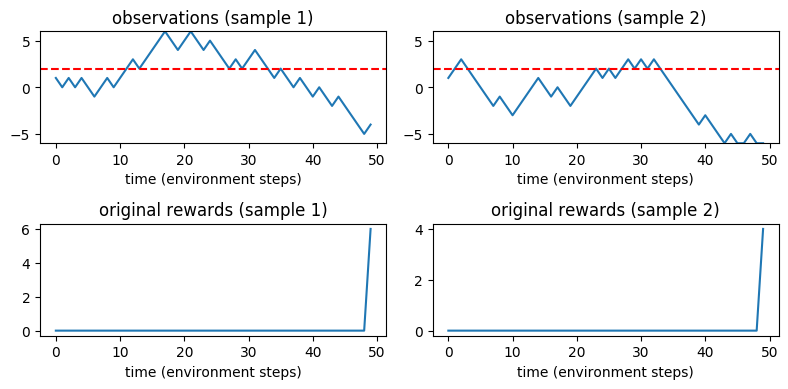

In [3]:
obs0, a0, r0 = env.__getitem__(3)
obs1, a1, r1 = env.__getitem__(25)
fig, axes = plt.subplots(2, 2, figsize=(8, 4), dpi=100)
axes[0, 0].plot(obs0.argmax(-1) - 6)
axes[0, 1].plot(obs1.argmax(-1) - 6)
axes[0, 0].set_ylim(-6, 6)
axes[0, 1].set_ylim(-6, 6)
axes[0, 0].axhline(2, linestyle='--', color='r')
axes[0, 1].axhline(2, linestyle='--', color='r')
axes[0, 0].set_title('observations (sample 1)')
axes[0, 1].set_title('observations (sample 2)')
axes[0, 0].set_xlabel('time (environment steps)')
axes[0, 1].set_xlabel('time (environment steps)')

axes[1, 0].plot(r0)
axes[1, 1].plot(r1)
axes[1, 0].set_title('original rewards (sample 1)')
axes[1, 1].set_title('original rewards (sample 2)')
axes[1, 0].set_xlabel('time (environment steps)')
axes[1, 1].set_xlabel('time (environment steps)')

fig.tight_layout()

... we can see that we created a delayed reward task. Everytime the agent is at position 2 it receives +1 reward at the end of the sequence.

Now let's see what RUDDER can do for us in such a case.

<h2 style="color:rgb(0,120,170)">Training a reward redistribution model</h2>

We will now train an LSTM model to perform reward redistribution on this task.

<h3 style="color:rgb(0,120,170)">Defining the model</h3>

Our model will consist of one LSTM layer with 16 cells. We will feed concatenated actions and observations timestep by timestep into the network, we could also use separate networks to preprocess actions and observations.

We will start with a simplified LSTM model without forget gate and without output gate. Additionally, we will only connect the input gate to the recurrent connections and the cell input to the forward connections. The output function of our LSTM will be linear since we are performing regression to predict the return value.

In cases our model would not be good enough to predict the return at the end of the sequence, we would have to increase the model complexity until it is good enough. You can do this by including output gate, forget gate, and fully connected gates, in this order.

In [4]:
class Net(torch.nn.Module):
    def __init__(self, n_positions, n_actions, n_lstm):
        super(Net, self).__init__()
        
        # This will create an LSTM layer where we will feed the concatenate
        self.lstm1 = LSTMLayer(
            in_features=n_positions+n_actions, out_features=n_lstm, inputformat='NLC',
            # cell input: initialize weights to forward inputs with xavier, disable connections to recurrent inputs
            w_ci=(torch.nn.init.xavier_normal_, False),
            # input gate: disable connections to forward inputs, initialize weights to recurrent inputs with xavier
            w_ig=(False, torch.nn.init.xavier_normal_),
            # output gate: disable all connection (=no forget gate) and disable bias
            w_og=False, b_og=False,
            # forget gate: disable all connection (=no forget gate) and disable bias
            w_fg=False, b_fg=False,
            # LSTM output activation is set to identity function
            a_out=lambda x: x
        )
        
        # After the LSTM layer, we add a fully connected output layer
        self.fc_out = torch.nn.Linear(n_lstm, 1)
    
    def forward(self, observations, actions):
        # Process input sequence by LSTM
        lstm_out, *_ = self.lstm1(torch.cat([observations, actions], dim=-1),
                                  return_all_seq_pos=True  # return predictions for all sequence positions
                                  )
        net_out = self.fc_out(lstm_out)
        return net_out


# Create Network
device = 'cpu'
net = Net(n_positions=n_positions, n_actions=2, n_lstm=16)
_ = net.to(device)

<h3 style="color:rgb(0,120,170)">Defining the loss function</h3>

As mentioned in the overview, we will train on two tasks:

1. The **main task** to train on is to predict the return of each sample at the end of the sequence.
2. The **auxiliary task** is to train the model to predict the final return at every sequence position. This will allow us to perform contribution analysis via differences of predictions. In some cases this helps to push the reward further back in time. Predicting the final return at every sequence position will typically be a lot more difficult for the LSTM. However, the LSTM does not need to be perfect at this task since having a correct return decomposition depends only on the prediction at the last timestep (main task). 

We do not have any intermediate rewards in the sequence, so we will only use these two tasks (main task, auxiliary task). We will downweight the auxiliary task with a factor of 0.5. Given the model output (=predictions) and the sequence of rewards we compute our loss as follows:

In [5]:
def lossfunction(predictions, rewards):
    returns = rewards.sum(dim=1)
    # Main task: predicting return at last timestep
    main_loss = torch.mean(predictions[:, -1] - returns) ** 2
    # Auxiliary task: predicting final return at every timestep ([..., None] is for correct broadcasting)
    aux_loss = torch.mean(predictions[:, :] - returns[..., None]) ** 2
    # Combine losses
    loss = main_loss + aux_loss * 0.5
    return loss

<h3 style="color:rgb(0,120,170)">Training the model</h3>

Now we train our model:

In [6]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-5)

update = 0
n_updates = 10000
running_loss = 100.
progressbar = tqdm.tqdm(total=n_updates)
while update < n_updates:
    for data in env_loader:
        # Get samples
        observations, actions, rewards = data
        observations, actions, rewards = observations.to(device), actions.to(device), rewards.to(device)
        
        # Reset gradients
        optimizer.zero_grad()
        
        # Get outputs for network
        outputs = net(observations=observations, actions=actions)
        
        # Calculate loss, do backward pass, and update
        loss = lossfunction(outputs[..., 0], rewards)
        loss.backward()
        running_loss = running_loss*0.99 + loss*0.01
        optimizer.step()
        update += 1
        progressbar.set_description(f"Loss: {running_loss:8.4f}")
        progressbar.update(1)

progressbar.close()

Loss:   0.2847: 100%|██████████| 10000/10000 [03:19<00:00, 50.24it/s]


<h3 style="color:rgb(0,120,170)">Inspecting the reward redistribution</h3>

We can now compute the reward redistribution as the differences of predictions of our trained model. In the optimal case, the reward would be redistributed to the actions that caused the reward and return. In practice, it will be distributed to what the model uses to predict the return, which might e.g. be prominent states. This is where the auxiliary task will help to move the reward further back.

Let us take a look at the reward redistribution of our trained model:

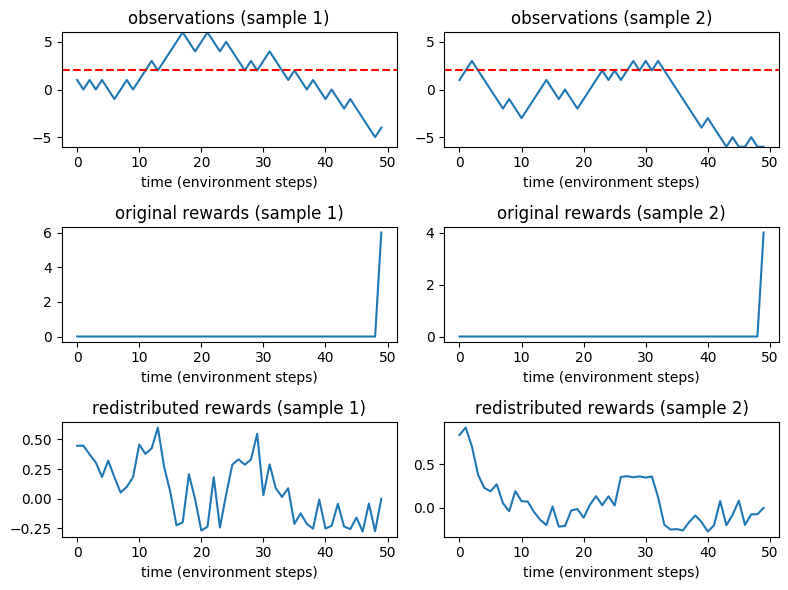

In [7]:
# Load 2 samples
obs0, a0, r0 = env.__getitem__(3)
obs1, a1, r1 = env.__getitem__(25)

# Apply our reward redistribution model to the samples
observations = torch.stack([torch.Tensor(obs0).to(device), torch.Tensor(obs1).to(device)], dim=0)
actions = torch.stack([torch.Tensor(a0).to(device), torch.Tensor(a1).to(device)], dim=0)
predictions = net(observations=observations.to(device), actions=actions.to(device))

# Use the differences of predictions as redistributed reward
redistributed_reward = predictions[:, 1:] - predictions[:, :-1]

# Pad the redistributed_reward with 0 at the last timestep
redistributed_reward = torch.cat([redistributed_reward, redistributed_reward[:, :1]*0.], dim=1)
redistributed_reward = redistributed_reward.cpu().detach().numpy()
rr0, rr1 = redistributed_reward[0], redistributed_reward[1]

fig, axes = plt.subplots(3, 2, figsize=(8, 6), dpi=100)
axes[0, 0].plot(obs0.argmax(-1) - 6)
axes[0, 1].plot(obs1.argmax(-1) - 6)
axes[0, 0].set_ylim(-6, 6)
axes[0, 1].set_ylim(-6, 6)
axes[0, 0].axhline(2, linestyle='--', color='r')
axes[0, 1].axhline(2, linestyle='--', color='r')
axes[0, 0].set_title('observations (sample 1)')
axes[0, 1].set_title('observations (sample 2)')
axes[0, 0].set_xlabel('time (environment steps)')
axes[0, 1].set_xlabel('time (environment steps)')

axes[1, 0].plot(r0)
axes[1, 1].plot(r1)
axes[1, 0].set_title('original rewards (sample 1)')
axes[1, 1].set_title('original rewards (sample 2)')
axes[1, 0].set_xlabel('time (environment steps)')
axes[1, 1].set_xlabel('time (environment steps)')

axes[2, 0].plot(rr0)
axes[2, 1].plot(rr1)
axes[2, 0].set_title('redistributed rewards (sample 1)')
axes[2, 1].set_title('redistributed rewards (sample 2)')
axes[2, 0].set_xlabel('time (environment steps)')
axes[2, 1].set_xlabel('time (environment steps)')

fig.tight_layout()

We can see that the reward that was originally only given at the end is moved to actions that bring the agent closer to position 2.

That means that **we do not recover the environment** where the agent receives +1 reward for being at position 2 **but instead get an environment with rewards that have even shorter delay**, since the actions towards position 2 are immediately rewarded.

... and we achieved all of this with a **supervised ML approach**!

<h3 style="color:rgb(0,120,170)">A note on LSTM training</h3>

Take a look at the cell states and activations to check if your LSTM is doing something useful or just overfits to e.g. the sequence length or goes into saturation somewhere.

The LSTM states after training would look something like this for sample 1 in the previous plots:

  Plotting LSTM states...

/home/michael/.local/lib/python3.6/site-packages/widis_lstm_tools/nn.py:853: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


 done! (0.2668669sec)


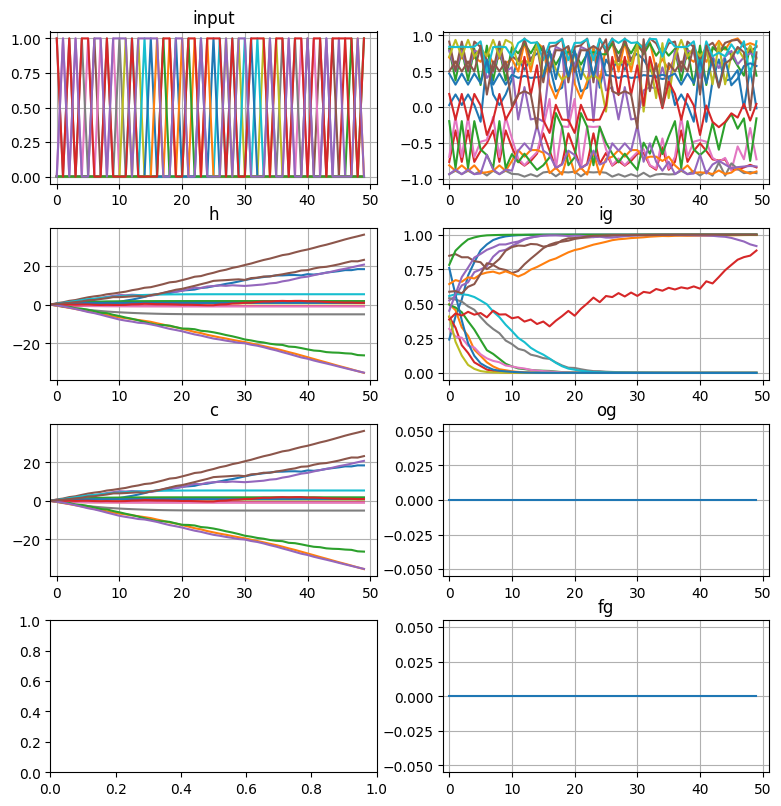

In [8]:
# Plost LSTM states for first sample of last processed minibatch
net.lstm1.plot_internals(filename=None, show_plot=True, mb_index=0, fdict=dict(figsize=(8, 8), dpi=100))

<h2 style="color:rgb(0,120,170)">What is left to do?</h2>

At this point you might already be able to assess whether RUDDER helps in your task. You then have to set up a lessons buffer and feed your RL agent/method with the redistributed reward, as described in points 4 and 5 in the overview.

For more details please see our [blog](https://www.jku.at/index.php?id=16426), [paper](https://arxiv.org/abs/1806.07857), and our [RUDDER repo](https://github.com/ml-jku/rudder).

Many thanks to Johannes Brandstetter for proof-reading and testing!

I hope this tutorial was able to help you and wish you the best for your RL endeavors!

-- Michael Widrich (widi)